In [1]:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

import copy
import time

import warnings
warnings.filterwarnings("ignore")

plt.ion()

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(25),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [4]:
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=test_transform, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


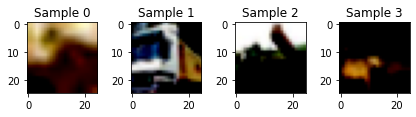

In [5]:
fig = plt.figure()

num_show = 4
for i in range(num_show):
    sample = train_dataset[i]
    ax = plt.subplot(1, num_show, i+1)
    plt.tight_layout()
    ax.set_title("Sample "+str(i))
    plt.imshow(sample[0].permute(1, 2, 0))

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [45]:
batch_size = 64
num_workers = 8
learning_rate = 0.003
num_epochs = 5
shuffle_train_loader = True

In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_train_loader, num_workers=num_workers)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

In [24]:
train_size = len(train_dataset)
test_size = len(test_dataset)

In [25]:
print('Train Size:', train_size)
print('Test Size:', test_size)

Train Size: 50000
Test Size: 10000


In [47]:
train_loader_size = len(train_dataloader)
test_loader_size = len(test_dataloader)

In [48]:
print('Train Steps:', train_loader_size)
print('Test Steps:', test_loader_size)

Train Steps: 782
Test Steps: 157


In [51]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    start_train_time = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    n_show = 5
    train_show = train_loader_size // n_show
    test_show = test_loader_size // n_show
    best_acc = 0.0
    print(f'Start Training\nTrain Show = {train_show}\nTest Show = {test_show}')

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))
        print('-'*10)
        
        model.train()
        running_loss = 0.0
        running_corrects = 0

        for i, (images, targets) in enumerate(train_dataloader):
            
            images = images.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item() * len(targets)
            running_corrects += torch.sum(preds == targets)

            if (i+1) % train_show == 0:
                print(f'Epoch: [{epoch+1}/{num_epochs}], Step [{i+1}/{train_loader_size}], Loss = {loss.item()}')

        scheduler.step()
    
        epoch_loss = running_loss / train_size
        epoch_acc = running_corrects / train_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for i, (images, targets) in enumerate(test_dataloader):

            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(False):
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, targets)

            running_loss += loss.item() * len(targets)
            running_corrects += torch.sum(preds == targets)

            if (i+1) % test_show == 0:
                print(f'Epoch: [{epoch+1}/{num_epochs}], Step [{i+1}/{test_loader_size}], Loss = {loss.item()}')

        epoch_loss = running_loss / test_size
        epoch_acc = running_corrects / test_size
        print('{} Loss: {:.4f} Acc: {:.4f}'.format('Test', epoch_loss, epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_train_time
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model


In [12]:
model = models.resnet101(pretrained=False)

In [13]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [52]:
model = train_model(model, criterion, optimizer, scheduler, 1)

Start Training
Train Show = 156
Test Show = 31
Epoch 1/1
----------
Epoch: [1/1], Step [156/782], Loss = 1.595300555229187
Epoch: [1/1], Step [312/782], Loss = 1.740244746208191
Epoch: [1/1], Step [468/782], Loss = 1.5289157629013062
Epoch: [1/1], Step [624/782], Loss = 1.7686121463775635
Epoch: [1/1], Step [780/782], Loss = 1.9263532161712646
Train Loss: 1.7051 Acc: 0.3787
Epoch: [1/1], Step [31/157], Loss = 1.695792555809021
Epoch: [1/1], Step [62/157], Loss = 1.6691614389419556
Epoch: [1/1], Step [93/157], Loss = 1.7106437683105469
Epoch: [1/1], Step [124/157], Loss = 1.5731467008590698
Epoch: [1/1], Step [155/157], Loss = 1.7266994714736938
Test Loss: 1.6750 Acc: 0.3867

Training complete in 2m 50s
Best val Acc: 0.386700


In [ ]:
def evaluate(model, criterion):

    start_time = time.time()

    running_loss = 0.0
    running_corrects = 0

    for i, (images, targets) in enumerate(test_dataloader):

        images = images.to(device)
        targets = targets.to(device)

        with torch.set_grad_enabled(False):

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, targets)

        running_loss += loss.item() * len(targets)
        running_corrects += torch.sum(preds == targets)

    total_loss = running_loss / test_size
    total_acc = running_corrects / test_size
    elapsed_time = time.time() - start_time

    print('###### SUMMARY ######')
    print('Elapsed Time: {}'.format(elapsed_time))
    print('Total Loss: {}'.format(total_loss))
    print('Total Acc : {}'.format(total_acc))

In [ ]:
evaluate(model, criterion)

###### SUMMARY ######
Elapsed Time: 74.99072456359863
Total Loss: 1.7956983129501343
Total Acc : 0.33079999685287476


In [ ]:
test_dataset.transform = transforms.ToTensor()

In [ ]:
def visualization(model):

    num_show = 3
    fig = plt.figure()
    
    cnt = 1
    for k, (images, targets) in enumerate(test_dataloader):

        with torch.set_grad_enabled(False):
            outputs = model(images.to(device))
            _, preds = torch.max(outputs, 1)

        for i in range(len(images)):

            ax = plt.subplot(num_show, 4, 4*k+i+1)
            ax.set_title('{}[{}]'.format(classes[preds[i]], classes[targets[i]]))
            plt.imshow(images[i].permute(1, 2, 0))
            
        if cnt == num_show:
            return
        cnt += 1
    
    plt.show()

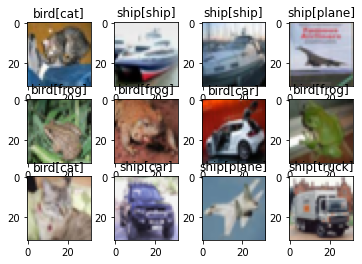

In [ ]:
visualization(model)